In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

### Ranking criteria SSIM and PSNR Scores
- SSIM : structural similarity index, uses luminance, contrast, and structure to capture perceptual differences in images. A score closer to 1 implies high similarity and good quality. SSIM score close to 0 suggests images have some similarity but very notable diff

- PSNR: Peak Signal-to-Noise Ratio higher the score,higher img quality and less distortion and noise


In [3]:
#importing pytorch
import torch

#for importing class used to generate images using the Stable Diffusion model
from diffusers import StableDiffusionPipeline

#image module
from PIL import Image

#MISC
import numpy as np

#for SSIM and PSNR calculation
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr



### Model initialisation
- loading the Stable diffusion model from a pre-trained checpkoint
- it's loaded as a pipline

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

#moving the model to the GPU (cuda)
pipe = pipe.to("cuda")

#### Function to create a grid of images, takes a list of imgs, no. of rows and columns and combines them in a grid

In [5]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


### Image generation

In [30]:
#no. of images to be generated
num_images = 5

#creating a list of prompts based on the total no. of images but with same text
prompt = ["A blue vase and it contains red dahlias"] * num_images

#added more number of inference steps to improve the results
images = pipe(prompt,num_inference_steps=200).images

  0%|          | 0/200 [00:00<?, ?it/s]

### Calculating SIM and PSNR scores

In [35]:
# SSIM and PSNR scores for each generated image when comparing to other images
ssim_scores = []
psnr_scores = []
for i, image1 in enumerate(images):
    for j, image2 in enumerate(images):
        if i != j:  #in order to prevent self comparison
            #converting images to NumPy arrays
            image1_np = np.array(image1)
            image2_np = np.array(image2)

            #calculating SSIM score
            #multichannel=True is indicating that image has multiple color channels
            ssim_score = ssim(image1_np, image2_np, multichannel=True)
            #calculating PSNR score
            psnr_score = psnr(image1_np, image2_np)

            ssim_scores.append(ssim_score)
            psnr_scores.append(psnr_score)




In [39]:
#calculating average of SSIM and PSNR scores for each image
#using list comprehension to compute the avg
avg_ssim_scores = [sum(ssim_scores[i:i+num_images-1]) / (num_images - 1) for i in range(0, len(ssim_scores), num_images-1)]
avg_psnr_scores = [sum(psnr_scores[i:i+num_images-1]) / (num_images - 1) for i in range(0, len(psnr_scores), num_images-1)]


#assigning weights to both scores
weight_ssim = 1.0
weight_psnr = 0.5

In [40]:
#calculating the weighted scores for each image usinga assigned weights
#using a weighted average of SSIM and PSNR and then normalising by the sum of weights

weighted_scores = [
    (weight_ssim * ssim_score + weight_psnr * psnr_score) / (weight_ssim + weight_psnr)
    for ssim_score, psnr_score in zip(avg_ssim_scores, avg_psnr_scores)
]


Rank 1: SSIM: 0.23, PSNR: 8.50


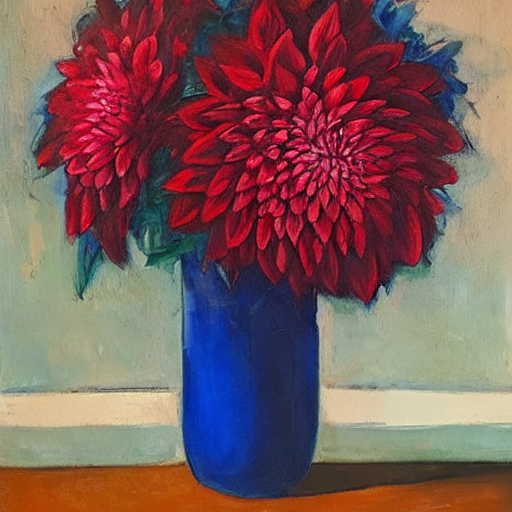

Rank 2: SSIM: 0.25, PSNR: 8.36


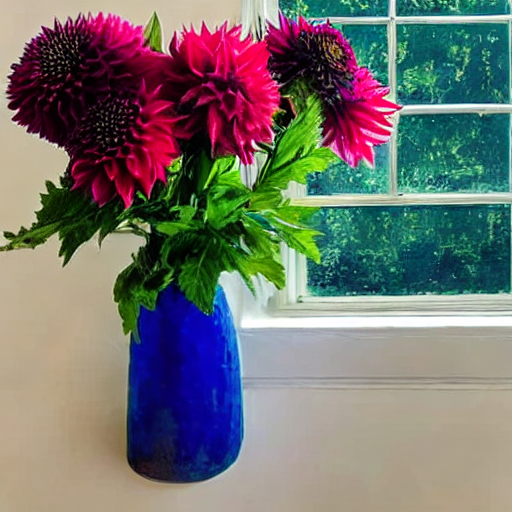

Rank 3: SSIM: 0.25, PSNR: 8.95


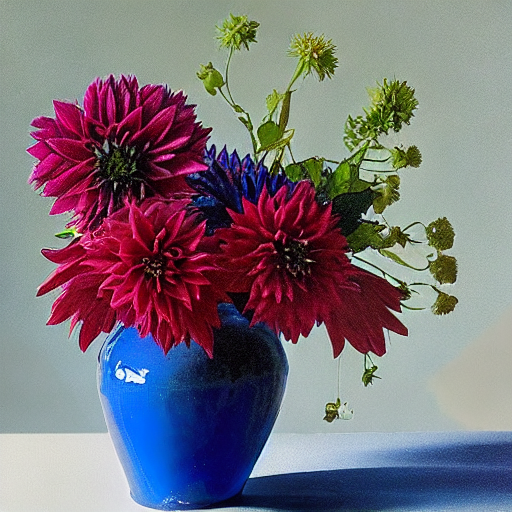

Rank 4: SSIM: 0.26, PSNR: 9.43


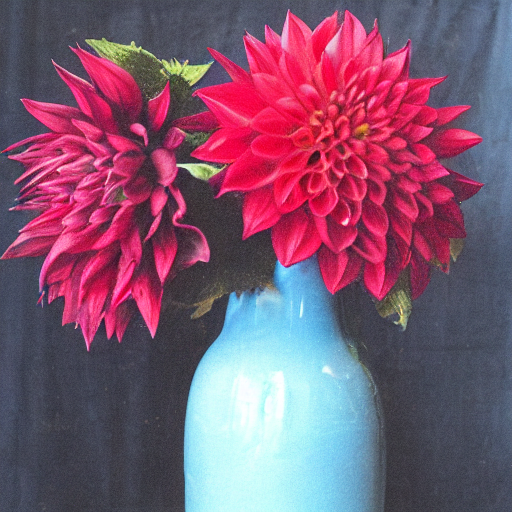

Rank 5: SSIM: 0.23, PSNR: 8.87


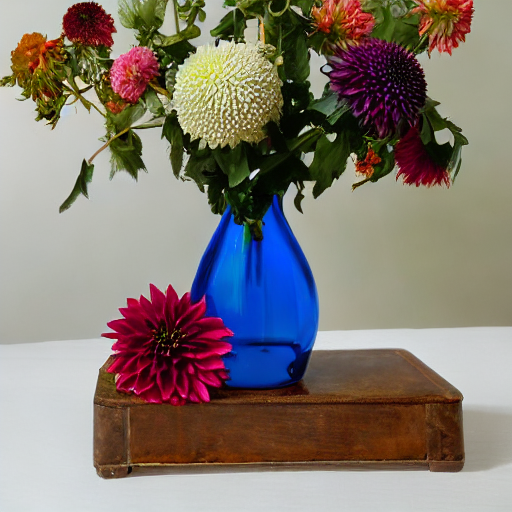

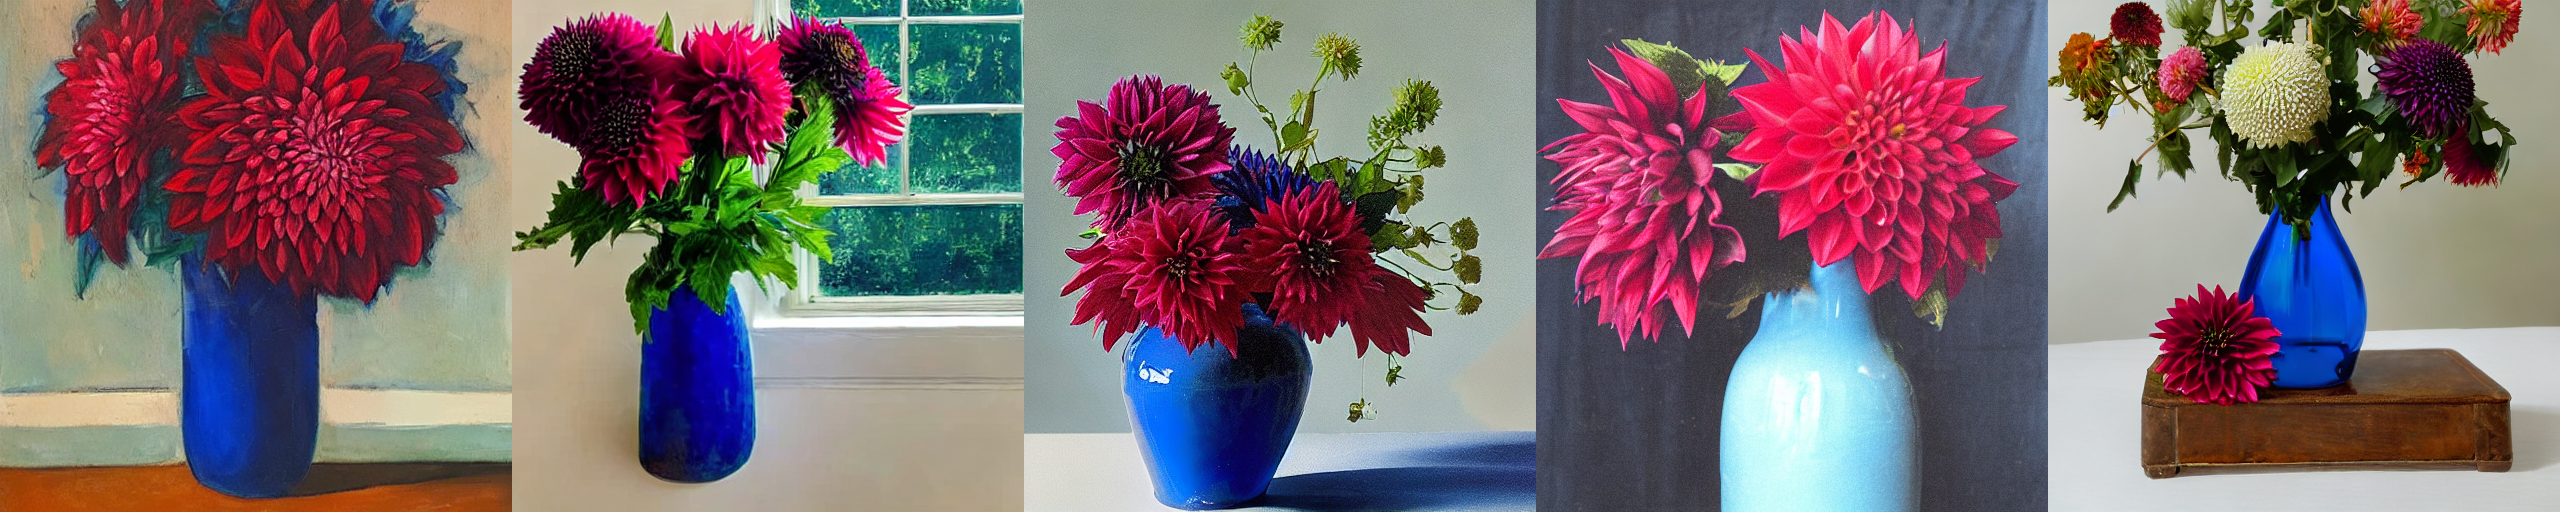

In [41]:
#ranking the images on the basis of the weighted scores
ranked_images = [image for _, image in sorted(zip(weighted_scores, images), reverse=True)]

#dumping the ranked images to local
for i, image in enumerate(ranked_images):
    image.save(f"ranked_image_{i}.png")

#displaying a grid of the ranked images
grid = image_grid(ranked_images, rows=1, cols=num_images)

#showing the images from best to worst
for i, (image, rank) in enumerate(zip(ranked_images, range(1, num_images + 1))):
    print(f"Rank {rank}: SSIM: {avg_ssim_scores[i]:.2f}, PSNR: {avg_psnr_scores[i]:.2f}")
    display(image)

display(grid)

## Ways to improve the process

- Tuning the weights assigned to SSIM and PSNR further ( sorta like hyperparameter tuning)
- Using a reference image and compute SSIM scores relative to that
- Visual Inspection and then feedback : user can review and based on feedback adjust the model params, or metrics 
- Using even more advvanced metrics like Precision and Recall (PR) Curves, Fréchet Inception Distance, etc.